This notebook requires the [`autograd` package](https://github.com/HIPS/autograd).
To install `autograd` run the following in a terminal (mac or linux), or Anaconda prompt (windows)
```
conda install -c conda-forge autograd
```

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np

# add the data folder to path (this specifies a relative path to where my data is stored)
import os, sys
sys.path.append(os.path.join(os.getcwd(), "../data"))
from data.data_utils import rosenbrock



Recall our MLP forward pass computations

In [11]:
def forward_pass(x, W1, W2, b1, b2, phi1, phi2):
    """
    forward-pass for an MLP with a single hidden layer of M neurons
    Inputs:
        x : (N, 2) training inputs
        W1 : (M, 2) weights of first (hidden) layer
        W2 : (1, M) weights of second (output) layer
        b1 : (M, 1) biases of first (hidden) layer
        b2 : (1, 1) biases of second (output) layer
        phi1 : 1st layer activation function
        phi2 : 2nd layer activation function
    Outputs:
        Fhat : (N, 1) output of the neural network at training inputs
    """
    H1 = phi1(np.dot(x, W1.T) + b1.T) # layer 1 neurons, shape (N, M)
    Fhat = phi2(np.dot(H1, W2.T) + b2.T) # layer 2 neurons, shape (N, 1)
    return Fhat

Initialize the weights and biases in the neural network, as well as the activation functions

In [12]:
np.random.seed(0)
scale = 0.1 # standard deviation of initialization
M = 50 # number of neurons in hidden layer
W1 = scale * np.random.randn(M, 2)
W2 = scale * np.random.randn(1, M)
b1 = scale * np.random.randn(M, 1)
b2 = scale * np.random.randn(1, 1)
phi1 = lambda z: np.maximum(0., z) # relu on hidden layer
phi2 = lambda z: z # linear activation on output layer

Create a training set using the two-dimensional Rosenbrock dataset and plot the initial neural network compared to the exact Rosenbrock function

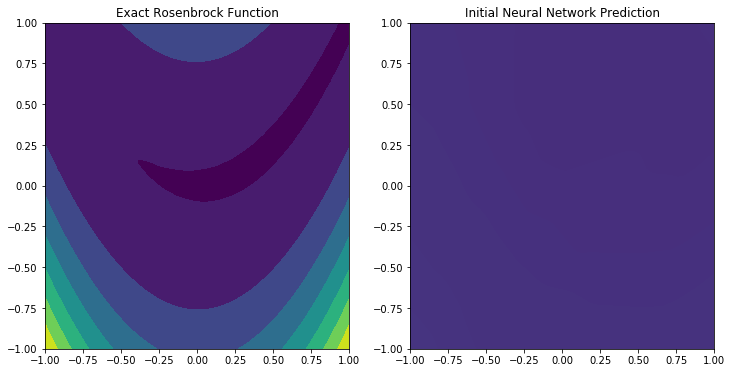

In [13]:
x_train = 2.*np.random.rand(1000, 2) - 1
y_train = rosenbrock(x_train)
y_train = (y_train - y_train.mean())/y_train.std() # transform training set to zero mean and unit variance

# get a grid to evaluate the exact rosenbrock function on
xx1, xx2 = np.meshgrid(np.linspace(-1,1,num=50), np.linspace(-1,1,num=50))
x_test = np.c_[xx1.flatten(), xx2.flatten()]
y_test = (rosenbrock(x_test).reshape((50,50)) - np.mean(rosenbrock(x_train)))/np.std(rosenbrock(x_train))

# plot
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].contourf(xx1, xx2, y_test, vmin=y_test.min(), vmax=y_test.max())
axs[0].set_title("Exact Rosenbrock Function")
axs[1].contourf(xx1, xx2, forward_pass(x_test, W1, W2, b1, b2, phi1, phi2).reshape((50,50)), 
                vmin=y_test.min(), vmax=y_test.max());
axs[1].set_title("Initial Neural Network Prediction");

define an optimizer and a loss function to minimize

In [14]:
def update_parameters(w, grad_w, learning_rate=1.):
    """
    perform gradient descent update to minimize an objective
    Inputs:
        w : vector of parameters
        grad_w : gradient of the loss with respect to the parameters
        learning_rate : learning rate of the optimizer
    """
    return w - learning_rate * grad_w


def least_squares_loss(W1, W2, b1, b2, phi1, phi2, x, y):
    """ compute the least squares loss for the MLP. The learnable parameters are the inputs. """
    return np.sum(np.square(forward_pass(x, W1, W2, b1, b2, phi1, phi2) - y))

Define a function that computes the gradient of the parameters with respect to the least squares loss using the `autograd.grad` function.
Note the `argnum` arguement specifies which inputs to our loss we wish to find the gradient with respect to.

In [15]:
from autograd import grad # The only autograd function you may ever need
least_squares_gradient = grad(least_squares_loss, argnum=[0,1,2,3])

Now train the neural network using gradient descent (just using full batch for now)

In [16]:
learning_rate = 0.0002
for i in range(2000):
    # compute the gradient
    W1_grad, W2_grad, b1_grad, b2_grad = least_squares_gradient(W1, W2, b1, b2, phi1, phi2, x_train, y_train)
    # update the parameters
    W1 = update_parameters(W1, W1_grad, learning_rate)
    W2 = update_parameters(W2, W2_grad, learning_rate)
    b1 = update_parameters(b1, b1_grad, learning_rate)
    b2 = update_parameters(b2, b2_grad, learning_rate)
    # print loss if nessessary
    if i==0 or (i+1) % 200 == 0:
        print("Iter %3d, loss = %.6f" % (i+1, least_squares_loss(W1, W2, b1, b2, phi1, phi2, x_train, y_train)))

Iter   1, loss = 926.423482
Iter 200, loss = 57.905487
Iter 400, loss = 27.644657
Iter 600, loss = 16.099811
Iter 800, loss = 11.373363
Iter 1000, loss = 9.786872
Iter 1200, loss = 8.788905
Iter 1400, loss = 6.256851
Iter 1600, loss = 5.213373
Iter 1800, loss = 4.761548
Iter 2000, loss = 4.246644


Now plot the prediction of the trained model alongside the exact function

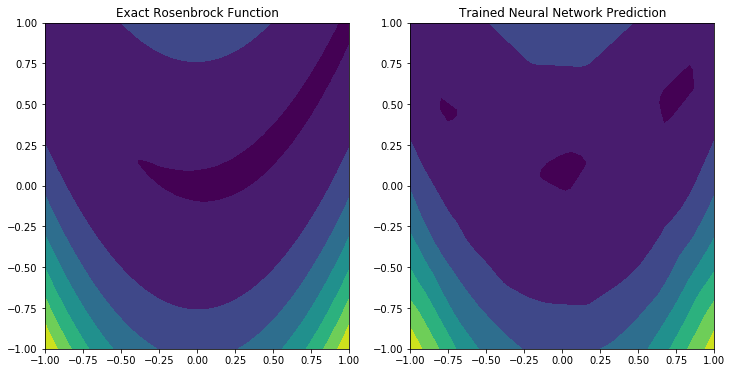

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].contourf(xx1, xx2, y_test, vmin=y_test.min(), vmax=y_test.max())
axs[0].set_title("Exact Rosenbrock Function")
axs[1].contourf(xx1, xx2, forward_pass(x_test, W1, W2, b1, b2, phi1, phi2).reshape((50,50)),
                vmin=y_test.min(), vmax=y_test.max());
axs[1].set_title("Trained Neural Network Prediction");

The `autograd` package can provide gradients for nearly all commonly used `numpy` functionality.
However, there are some limitations such as assigment to arrays.
For a summary of what it can and cannot do, see [here](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md#tldr-do-use).